<a href="https://colab.research.google.com/github/bhushanrajs/sciml_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [130]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/sciml_project/main/analysis_data.csv')
df = df.dropna()
print(df)

                            Model Name Girder Type  Nb     L    S  w_oh  ts_U  \
0       Tx28-L_45-Nb_4-S_60-O_15-ts_85        Tx28   4   540   72    18   8.5   
1      Tx28-L_45-Nb_4-S_60-O_15-ts_100        Tx28   4   540   72    18  10.0   
2       Tx28-L_45-Nb_4-S_60-O_20-ts_85        Tx28   4   540   72    24   8.5   
3      Tx28-L_45-Nb_4-S_60-O_20-ts_100        Tx28   4   540   72    24  10.0   
4       Tx28-L_45-Nb_4-S_60-O_25-ts_85        Tx28   4   540   72    30   8.5   
...                                ...         ...  ..   ...  ...   ...   ...   
2060   Tx84-L_160-Nb_4-S_80-O_35-ts_85        Tx84   4  1920   96    42   8.5   
2061   Tx84-L_160-Nb_4-S_90-O_30-ts_85        Tx84   4  1920  108    36   8.5   
2062   Tx84-L_160-Nb_4-S_90-O_35-ts_85        Tx84   4  1920  108    42   8.5   
2063  Tx84-L_160-Nb_4-S_100-O_25-ts_85        Tx84   4  1920  120    30   8.5   
2064  Tx84-L_160-Nb_4-S_100-O_35-ts_85        Tx84   4  1920  120    42   8.5   

      ts_O  fc_deck  fc_gir

In [131]:
tx_girders = {'Tx28' : {'D' : 28.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 6.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx34' : {'D' : 34.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 12.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx40' : {'D' : 40.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 18.75, 'd5' : 3.0, 'd6' : 4.0, 'd7' : 6.75},
              'Tx46' : {'D' : 46.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 22.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx54' : {'D' : 54.0, 'b1' : 36.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.0, 'd3' : 2.0, 'd4' : 30.0, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx62' : {'D' : 62.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 37.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx70' : {'D' : 70.0, 'b1' : 42.0, 'b2' : 7.0, 'b3' : 32.0, 'b4' : 2.0, 'b5' : 3.0, 'd1' : 3.5, 'd2' : 2.5, 'd3' : 2.0, 'd4' : 45.5, 'd5' : 3.0, 'd6' : 4.75, 'd7' : 8.75},
              'Tx84' : {'D' : 84.0, 'b1' : 58.0, 'b2' : 8.0, 'b3' : 38.0, 'b4' : 3.0, 'b5' : 3.0, 'd1' : 4.0, 'd2' : 3.5, 'd3' : 3.0, 'd4' : 55.75, 'd5' : 3.0, 'd6' : 6.0, 'd7' : 8.75}
              }

# bridge geometry data
L = df['L']/12 # span length in ft.
S = df['S']/12 # girder spacing in ft.
w_oh = df['w_oh']/12 # overhang width in ft.
ts = df['ts_U']/12 # thickness of overhang in ft.
girder = df['Girder Type']
girder_depth = []
for _, girder_type in girder.items():
  girder_depth.append(tx_girders[girder_type]['D'])
df['D'] = girder_depth

# intensity of railing dead load in kip/ft
b_rail = df['b_rail_left'] # width of railing
q_rail = (df['q_rail_left'] * b_rail * 12)/1000

# max bending moment in exterior girder G1 & interior girder G2 in kip-ft
bm1 = df['G1 - max_bm']/(1000*12)
bm2 = df['G2 - max_bm']/(1000*12)
bm3 = df['G3 - max_bm']/(1000*12)
bm4 = df['G4 - max_bm']/(1000*12)

# reaction in girders G1 & G2 in kip. (only A1 taken due to symmetry)
r1 = df['G1-A1-Y']/1000
r2 = df['G2-A1-Y']/1000
r3 = df['G3-A1-Y']/1000
r4 = df['G4-A1-Y']/1000

# line analysis with full railing load assumed to be applied on a girder
bm_line = q_rail * (L - 2*9/12)**2 / 8
r_line = q_rail * L / 2


# normalizing bending moments with respect to line analysis
n_bm1 = bm1 / bm_line
n_bm2 = bm2 / bm_line
n_bm3 = bm3 / bm_line
n_bm4 = bm4 / bm_line

# normalizing vertical reactions with respect to line analysis
n_r1 = r1 / r_line
n_r2 = r2 / r_line
n_r3 = r3 / r_line
n_r4 = r4 / r_line


df['n_bm1'] = n_bm1
df['n_bm2'] = n_bm2
df['n_r1'] = n_r1
df['n_r2'] = n_r2

In [132]:
print(n_bm1 + n_bm2 + n_bm3 + n_bm4)
print(n_r1 + n_r2 + n_r3 + n_r4)

0       0.990695
1       0.986348
2       0.998870
3       0.995075
4       1.007073
          ...   
2060    1.039071
2061    1.045995
2062    1.054395
2063    1.048749
2064    1.063360
Length: 2065, dtype: float64
0       1.000001
1       1.000001
2       1.000001
3       1.000001
4       1.000001
          ...   
2060    1.000001
2061    1.000001
2062    1.000001
2063    1.000001
2064    1.000001
Length: 2065, dtype: float64


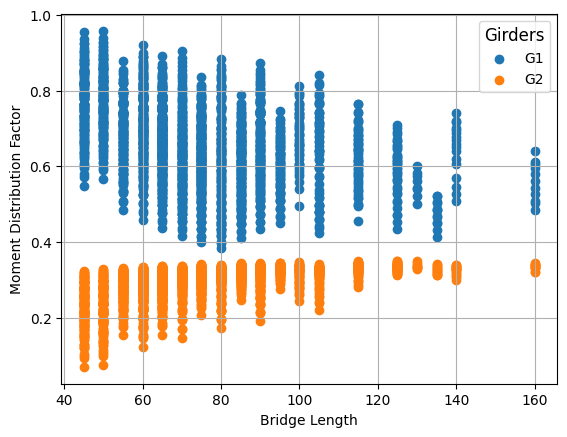

In [142]:
# Plot moment distribution factors
plt.scatter(L,n_bm1, label = "G1")
plt.scatter(L,n_bm2, label = "G2")

# axis labels
plt.xlabel(r'Bridge Length')
plt.ylabel(r'Moment Distribution Factor')

# display a legend, set its title
leg = plt.legend()
leg.set_title('Girders', prop={'size':12})

plt.grid() # show a grid

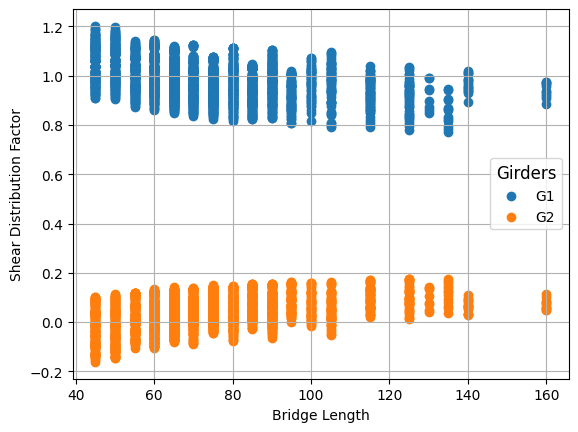

In [143]:
# Plot shear distribution factors
plt.scatter(L,n_r1, label = "G1")
plt.scatter(L,n_r2, label = "G2")

# axis labels
plt.xlabel(r'Bridge Length')
plt.ylabel(r'Shear Distribution Factor')

# display a legend, set its title
leg = plt.legend()
leg.set_title('Girders', prop={'size':12})

plt.grid() # show a grid

In [144]:
df_G1 = df[['L', 'S', 'w_oh', 'ts_U','D', 'n_bm1','n_bm2']]
df_G1.head()

,L,S,w_oh,ts_U,D,n_bm1,n_bm2
0,540,72,18,8.5,28.0,0.570854,0.319484
1,540,72,18,10.0,28.0,0.549410,0.323670
2,540,72,24,8.5,28.0,0.602907,0.306543
3,540,72,24,10.0,28.0,0.579155,0.313099
4,540,72,30,8.5,28.0,0.634685,0.293845


In [136]:
X = df_G1.copy(deep=True)
y = df[['n_bm1','n_bm2']]

tensor_y = torch.tensor(y.values, dtype=torch.float32)

X_train_target, X_val_test_target, y_train, y_val_test = train_test_split(X, y, test_size=0.2)
X_test_target, X_val_target, y_test, y_val = train_test_split(X_val_test_target, y_val_test, test_size=0.2)

In [137]:
X_train = X_train_target.drop(['n_bm1','n_bm2'], axis=1)
X_test = X_test_target.drop(['n_bm1','n_bm2'], axis=1)
X_val = X_val_target.drop(['n_bm1','n_bm2'], axis=1)

tensor_y_train = torch.tensor(y_train.values, dtype=torch.float32)
tensor_y_val = torch.tensor(y_val.values, dtype=torch.float32)
tensor_y_test = torch.tensor(y_test.values, dtype=torch.float32)

tensor_X_train = torch.tensor(X_train.values, dtype=torch.float32)
tensor_X_test = torch.tensor(X_test.values, dtype=torch.float32)
tensor_X_val = torch.tensor(X_val.values, dtype=torch.float32)


In [146]:
model = nn.Sequential(
    nn.Linear(5, 32),  # Input layer with 6 features and 64 units
    nn.ReLU(),        # Activation function (you can choose other activation functions)
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 2)   # Output layer with 64 units and 2 output units
)

# Training
optimizer = optim.Adam(model.parameters())
losses = []
epochs = 5000
for epoch in tqdm(range(epochs), desc='Model training progress'):
    y_pred = model(tensor_X_train)

    # Separate the predictions and targets for each output
    y_pred_output1 = y_pred[:, 0]  # First output is at index 0
    y_pred_output2 = y_pred[:, 1]  # Second output is at index 1

    y_true_output1 = tensor_y_train[:,0]
    y_true_output2 = tensor_y_train[:, 1]

    # Define the loss function for each output
    loss_fn_output1 = nn.MSELoss()
    loss_fn_output2 = nn.MSELoss()

    # Compute the loss for each output
    loss_output1 = loss_fn_output1(y_pred_output1, y_true_output1)
    loss_output2 = loss_fn_output2(y_pred_output2, y_true_output2)

    # Total loss (you can adjust this based on your specific requirements)
    total_loss = loss_output1 + loss_output2

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    losses.append(total_loss.item())

Model training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

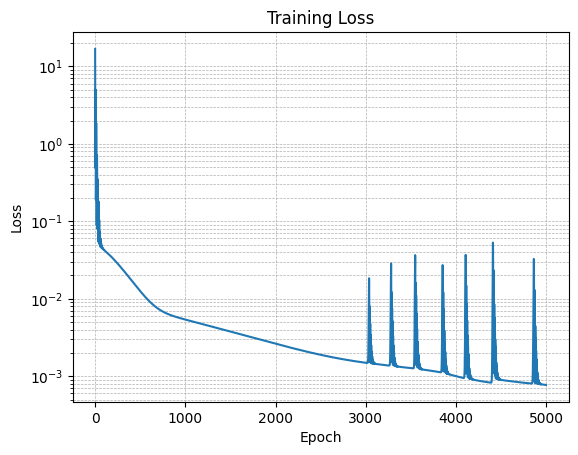

In [140]:
# Plot the loss on a semilog scale
plt.figure()
plt.semilogy(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [141]:
y_pred_test = model(tensor_X_test)
y_pred_output1 = y_pred_test[:, 0]  # Assuming the first output is at index 0
y_pred_output2 = y_pred_test[:, 1]  # Assuming the second output is at index 1

y_true_output1 = tensor_y_test[:,0]
y_true_output2 = tensor_y_test[:, 1]

# Define the loss function for each output
loss_fn_output1 = nn.MSELoss()
loss_fn_output2 = nn.MSELoss()

# Compute the loss for each output
loss_output1 = loss_fn_output1(y_pred_output1, y_true_output1)
loss_output2 = loss_fn_output2(y_pred_output2, y_true_output2)

# Total loss (you can adjust this based on your specific requirements)
total_loss = loss_output1 + loss_output2
print(f"Test loss is: {total_loss}")

Test loss is: 0.0008996232645586133
